In [89]:
import os
import csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from keras.models import Sequential,  Model
from keras.layers.core import Dense, Flatten, Activation, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, Cropping2D
import numpy as np
import pandas as pd
from scipy.misc import imread
import matplotlib.pyplot as plt
from math import *
import cv2
from keras.callbacks import ModelCheckpoint
import keras
from sklearn.model_selection import train_test_split
%matplotlib inline


print('All Packages Loaded')

All Packages Loaded


In [90]:
x = pd.read_csv('/home/carnd/test/data/driving_log.csv')
print("All Data Loaded")

All Data Loaded


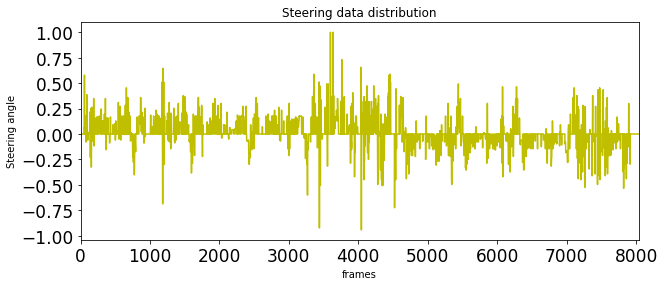

In [91]:
x.steering.plot(title='Steering data distribution', fontsize=17, figsize=(10,4), color= 'y')
plt.xlabel('frames')
plt.ylabel('Steering angle')
plt.show()

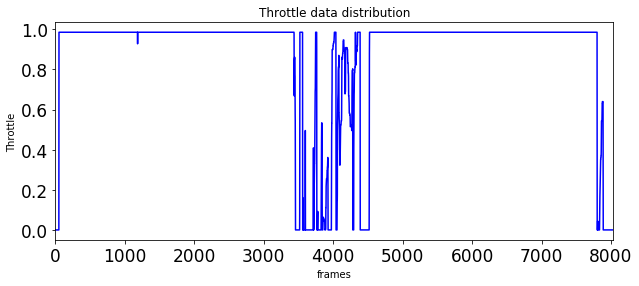

In [92]:
x.throttle.plot(title='Throttle data distribution', fontsize=17, figsize=(10,4), color= 'b')
plt.xlabel('frames')
plt.ylabel('Throttle')
plt.show()

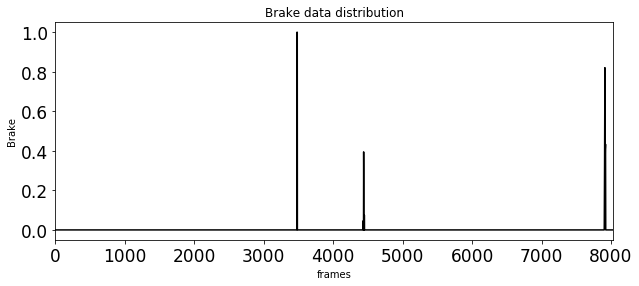

In [93]:
x.brake.plot(title='Brake data distribution', fontsize=17, figsize=(10,4), color= 'k')
plt.xlabel('frames')
plt.ylabel('Brake')
plt.show()

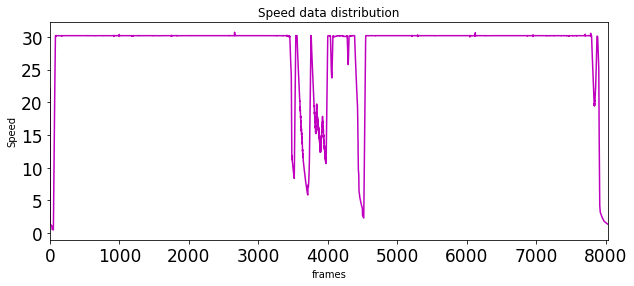

In [94]:
x.speed.plot(title='Speed data distribution', fontsize=17, figsize=(10,4), color= 'm')
plt.xlabel('frames')
plt.ylabel('Speed')
plt.show()

In [95]:
samples = [] 

with open('/home/carnd/test/data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None) 
    for line in reader:
        samples.append(line)

In [96]:
train_samples, validation_samples = train_test_split(samples,test_size=0.15) #simply splitting the dataset to train and validation set usking sklearn. .15 indicates 15% of the dataset is validation set

In [98]:

import cv2
import numpy as np
import sklearn
import matplotlib.pyplot as plt


def generator(samples, batch_size=32):
    num_samples = len(samples)
   
    while 1: 
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                    for i in range(0,3):
                        
                        name = '/home/carnd/test/data/IMG/'+batch_sample[i].split('/')[-1]
                        main_image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB) 
                        required_angle = float(batch_sample[3])
                        images.append(main_image)
                        
                     
                        
                        if(i==0):
                            angles.append(required_angle)
                        elif(i==1):
                            angles.append(required_angle+0.2)
                        elif(i==2):
                            angles.append(required_angle-0.2)
                        
                        
                        
                        images.append(cv2.flip(main_image,1))
                        if(i==0):
                            angles.append(required_angle*-1)
                        elif(i==1):
                            angles.append((required_angle+0.2)*-1)
                        elif(i==2):
                            angles.append((required_angle-0.2)*-1)
                            
                        """    
                        hsv = cv2.cvtColor(main_image, cv2.COLOR_RGB2HSV)
                        ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
                        hsv[:,:,2] =  hsv[:,:,2] * ratio
                        img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
                        images.append(img)
                        
                        if(i==0):
                            angles.append(required_angle*-1)
                        elif(i==1):
                            angles.append((required_angle+0.2)*-1)
                        elif(i==2):
                            angles.append((required_angle-0.2)*-1)
                        """
                          
                        
        
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield sklearn.utils.shuffle(X_train, y_train)
            


train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

## Type of Problem : Regression
### Problem Statement: Find the Steering angle, given images from three cameras, i.e Left, Centre and Right.

##### Checklist for creating the pipeline of the NVIDIA model : https://tinyurl.com/y88xelpb
1. Preprocess incoming data, centered around zero with small standard deviation 
2. Trim image the to train the network on the basis of the road and the steering angle only.
3. Layer 1 : Convolution Layer, Number of Filters : 24, Filter size= 5x5,  stride= 2x2.
4. Layer 2 : Convolution Layer, Number of Filters : 36, Filter Size = 5x5, stride = 2x2.
5. Layer 3 : Convolution Layer, Number of Filters : 48, Filter Size = 5x5, stride = 2x2.
6. Layer 4 : Convolution Layer, Number of Filters : 64, Filter Size = 3x3, stride = 1x1.
7. Layer 5 : Convolution Layer, Number of Filters : 64, Filter Size = 3x3, stride = 1x1.
8. Flatten the Image from a 2D format to a row based array.
9. Layer 6 : Fully Connected Layer
10. A dropout layer to avoid overfitting.
11. Layer 7 : Fully Connected Layer
12. Layer 8 : Fully Connected Layer

In [99]:
model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(160,320, 3), name='Normalization'))
model.add(Cropping2D(cropping=((60, 25),(0,0))))
model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation='elu', name='Conv1'))
model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='elu', name='Conv2'))
model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='elu', name='Conv3'))
model.add(Convolution2D(64, 3, 3, activation='relu', name='Conv4'))
model.add(Convolution2D(64, 3, 3, activation='relu', name='Conv5'))
model.add(Flatten())
model.add(Dense(50, activation='elu', name='FC1'))
model.add(Dense(10, activation='elu', name='FC2'))
model.add(Dense(1, name='output'))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Normalization (Lambda)           (None, 160, 320, 3)   0           lambda_input_5[0][0]             
____________________________________________________________________________________________________
cropping2d_5 (Cropping2D)        (None, 75, 320, 3)    0           Normalization[0][0]              
____________________________________________________________________________________________________
Conv1 (Convolution2D)            (None, 36, 158, 24)   1824        cropping2d_5[0][0]               
____________________________________________________________________________________________________
Conv2 (Convolution2D)            (None, 16, 77, 36)    21636       Conv1[0][0]                      
___________________________________________________________________________________________

In [100]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        print('BEGIN TRAINING')
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [101]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')

In [102]:
batch_history = LossHistory()

In [103]:
Early_Stopping=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')

In [104]:
Tensor_Board = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)



In [105]:
model.compile(loss='mse',optimizer='adam')
plot_model = model.fit_generator(train_generator, samples_per_epoch= len(train_samples), validation_data=validation_generator,callbacks = [batch_history, Tensor_Board ],nb_val_samples=len(validation_samples), nb_epoch=5,verbose=1)
model.save('model.h5')
print('Hurray! The Model has been Saved!')

Instructions for updating:
Please switch to tf.summary.merge_all.
BEGIN TRAINING
Epoch 1/5
6720/6830 [============================>.] - ETA: 0s - loss: 0.0424

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


6912/6830 [==============================] - 15s - loss: 0.0418 - val_loss: 0.0235
Epoch 2/5
6912/6830 [==============================] - 14s - loss: 0.0204 - val_loss: 0.0194
Epoch 3/5
6912/6830 [==============================] - 15s - loss: 0.0183 - val_loss: 0.0194
Epoch 4/5
6912/6830 [==============================] - 14s - loss: 0.0186 - val_loss: 0.0218
Epoch 5/5
6912/6830 [==============================] - 14s - loss: 0.0197 - val_loss: 0.0151
Hurray! The Model has been Saved!


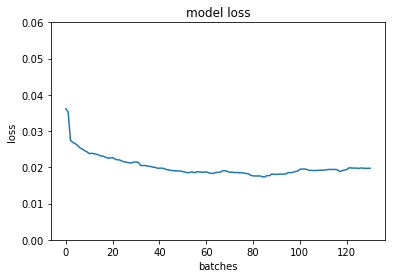

In [106]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

def plot_history(history):
    plt.plot(running_mean(history.losses, 50))
    plt.ylim(0, 0.06)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batches')
    plt.show()
    
plot_history(batch_history)


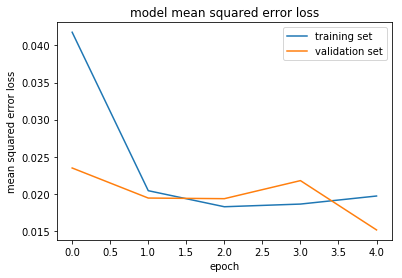

In [107]:
plt.plot(plot_model.history['loss'])
plt.plot(plot_model.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()